# Credit Card Prediction

## Context
A bank has an alarmingly high churn rate. Currently they have no processes in place to try prevent churn. I'm going to attempt to build a Predictive Model to estimate which customers will churn in order for us to proactively reach out to customers to attempt to retain them, as its much more costly to get new customers than it is to retain current business. The data will be inherently imbalanced so we will have to contend with this. (we hope its imbalanced or the churn is much worse than we thought!)

### Importing Modules

In [112]:
#%% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scikitplot as skplt

%matplotlib inline

from matplotlib import pyplot
from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold
from sklearn.metrics import roc_curve,accuracy_score,f1_score,auc,confusion_matrix,roc_auc_score,plot_confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier

### Read in Data

In [2]:
df = pd.read_csv("/Users/cameronlooney/Downloads/BankChurners.csv")

## High level view of Data

In [3]:
print(df.head())

   CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1       

There are several columns that we will drop as they wont be useful for our analysis. In this case we need to make sure explainability is a top priority. Its great having fancy features and transformation but we need actionable insights for the sales team to use. 

### Drop columns

In [4]:
drop_columns = ['CLIENTNUM',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [5]:
df.drop(drop_columns,inplace = True, axis = 1)

### Unique Values 

In [6]:
print(df.nunique(axis=0))

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                7
Marital_Status                 4
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64


We have several nominal categorical features here, however the cardinality is relatively low meaning we wont create an insane amount of features through One Hot Encoding if we choose to go that route.

### Data Statistics

In [7]:
print(df.describe())

       Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    

Data looks relatively clean, nothing jumps out from our overview, we will need to examine further but everything seems to be in good working order

In [8]:
def missing_values(data):
    '''
    :param data: dataframe
    :return: dataframe with features, number of missing values and percentage of missing values,
    sort the dataframe by number of missing values
    '''
    missing_values = pd.DataFrame(data.isnull().sum()).reset_index()
    missing_values.columns = ['feature', 'missing_values']
    missing_values['percentage_missing_values'] = (missing_values['missing_values'] / len(data)) * 100
    missing_values = missing_values.sort_values('missing_values', ascending=False)
    return missing_values
print(missing_values(df))

                     feature  missing_values  percentage_missing_values
0             Attrition_Flag               0                        0.0
1               Customer_Age               0                        0.0
18       Total_Ct_Chng_Q4_Q1               0                        0.0
17            Total_Trans_Ct               0                        0.0
16           Total_Trans_Amt               0                        0.0
15      Total_Amt_Chng_Q4_Q1               0                        0.0
14           Avg_Open_To_Buy               0                        0.0
13       Total_Revolving_Bal               0                        0.0
12              Credit_Limit               0                        0.0
11     Contacts_Count_12_mon               0                        0.0
10    Months_Inactive_12_mon               0                        0.0
9   Total_Relationship_Count               0                        0.0
8             Months_on_book               0                    

We have been blessed by the data gods, with no missing values. 
If this wasnt the case there are several avenues to approach to fill missing values. 
#### Firstly, why do we care about missing values?
You may end up building a biased machine learning model which will lead to incorrect results if the missing values are not handled properly. Missing data can lead to a lack of precision in the statistical analysis. Alot of machine learning algorithms also dont play nicely with missing values, so we need strategies to address this as it is something we will deal with consistenty
#### Strategies 
- **Old Faithful:** The jackhammer approach to missing values is to just simply drop rows containing any. While this sounds brash it can be a viable strategy depending on the context. If you have 100,000 records and 20 records with missing values, dropping these values wont effect the overall model 
- **Imputing:** My go to strategy is imputing, which is filling the missing values based on statistical features, usually median, mean, mode. This can be highly effective especially if you understand your data well. You can also impute values using algorithms which can be highly effective. However there is a time tradeoff here. 
- **Ignoring:** We can also simply ignore the missing values and let them be and use algorithms that can deal with missing values. However this limits our choice in models considerably. It is usually best practice to handle the values rather than ignore

### Data Types 

In [9]:
print(df.dtypes)

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object


All features appear to be the correct data type

## Exploratory Data Analysis
Now we will examine the data more indepth. We will explore different variables and visualisations that will hopefully provide insights that will guide our model later on 

In [10]:
def get_dtypes(data,drop_col=[]):
    """Return the dtypes for each column of a pandas Dataframe
    Parameters
    ----------
    data : pandas Dataframe
    drop_col : columns to omit in a list
    Returns
    -------
    str_var_list, num_var_list, all_var_list
    
    """

    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    all_var_list = []

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes in (np.int, np.int64, np.uint, np.int32, np.float,
                               np.float64, np.float32, np.double)):
            str_var_list.remove(var)
            num_var_list.append(var)
    # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)

    all_var_list.extend(str_var_list)
    all_var_list.extend(num_var_list)
    
    return str_var_list, num_var_list, all_var_list
string_vars, num_vars,all_vars = get_dtypes(df)


/var/folders/yt/tb5v0shj3l17fyn2bw5qqw3h0000gn/T/ipykernel_12869/307497314.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (data[var].dtypes in (np.int, np.int64, np.uint, np.int32, np.float,
/var/folders/yt/tb5v0shj3l17fyn2bw5qqw3h0000gn/T/ipykernel_12869/307497314.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumP

In [11]:
print("Numeric Features:\n " + str(num_vars)+"\n\n")
print("String Variables: " + str(string_vars))


Numeric Features:
 ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


String Variables: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [12]:
# custom function for easy and efficient analysis of numerical univariate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def UVA_numeric(data, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,3), dpi = 100)
  
    #looping for each variable
    for j,i in enumerate(var_group):

    # calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()-data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # calculating points of standard deviation
        points = mean-st_dev, mean+st_dev

        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        sns.kdeplot(data[i], shade=True)
        sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
        sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
        sns.scatterplot([mean], [0], color = 'red', label = "mean")
        sns.scatterplot([median], [0], color = 'blue', label = "median")
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('density')
        plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                       round(kurt,2),
                                                                                                       round(skew,2),
                                                                                                       (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                       round(mean,2),
                                                                                                       round(median,2)))

In [13]:
num_vars

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

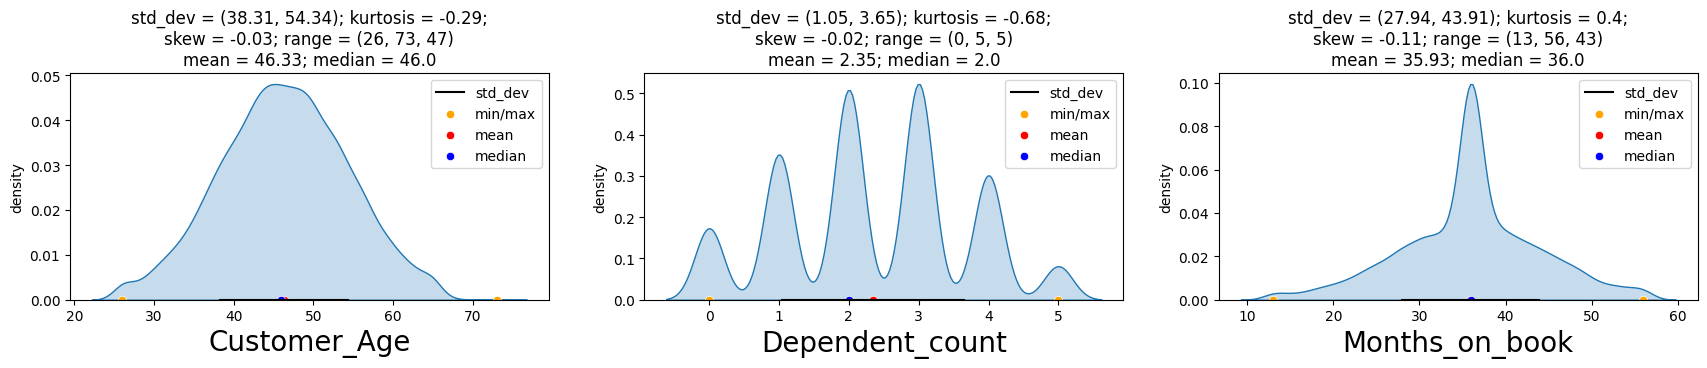

In [14]:
UVA_numeric(df,['Customer_Age',
 'Dependent_count',
 'Months_on_book',])

- Customer Age is normally distributed, with a mean and median that are roughly equal we dont need to do much to it
- Dependent count has the sine like distribution due to its discrete nature 
- Months on the books has a large standard deviation

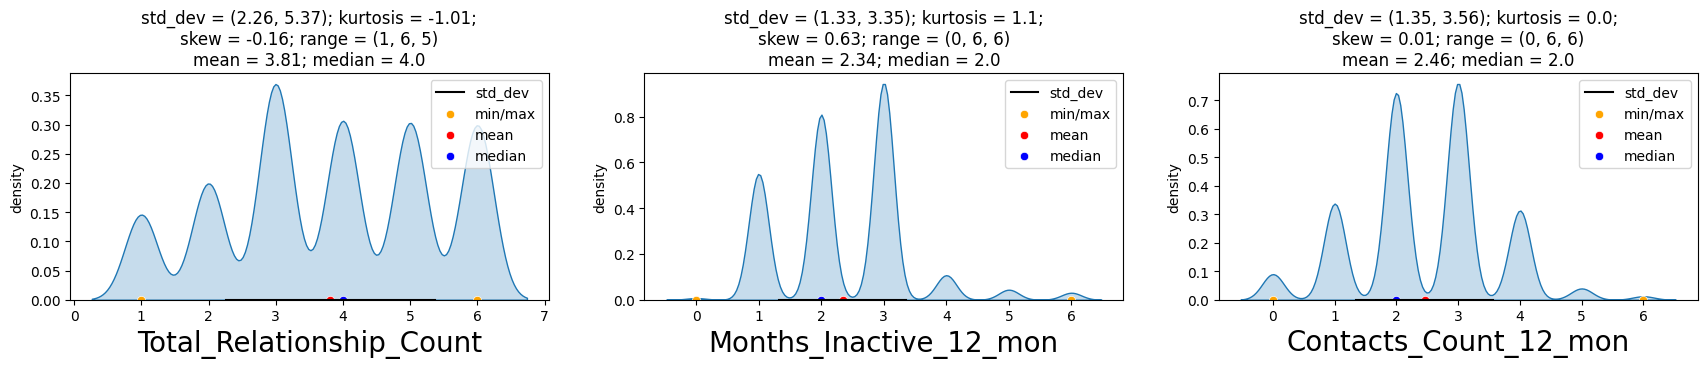

In [15]:
UVA_numeric(df,['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon'])

- All features here are discrete which explains the shame

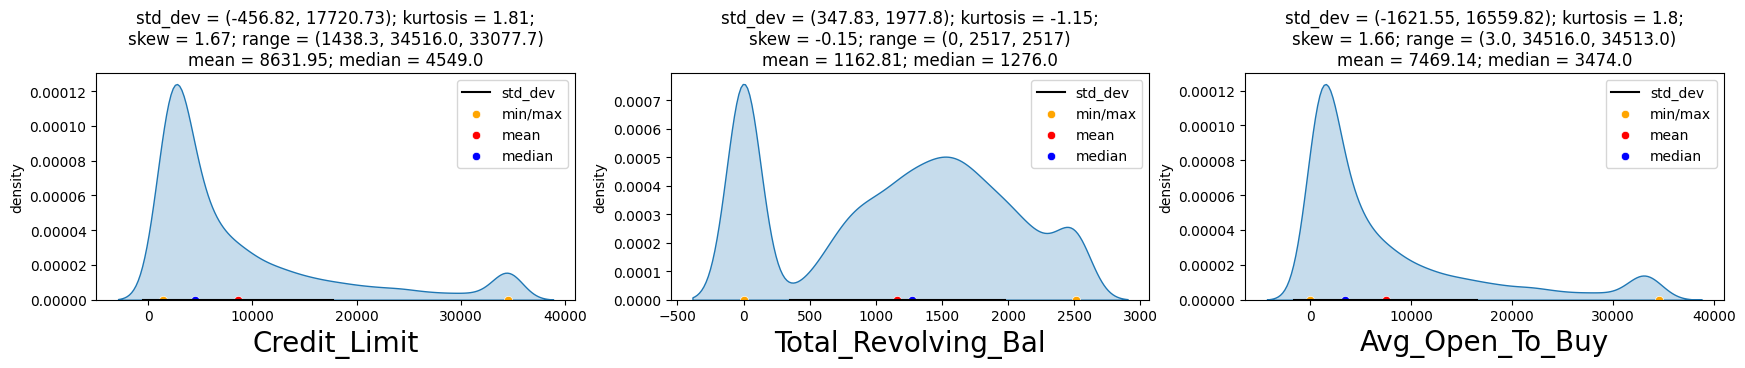

In [16]:
UVA_numeric(df,['Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy'])

- The distribution for these needs to be adjusted, it is currently log like with outliers on the right tail, this is due to the credit card cap

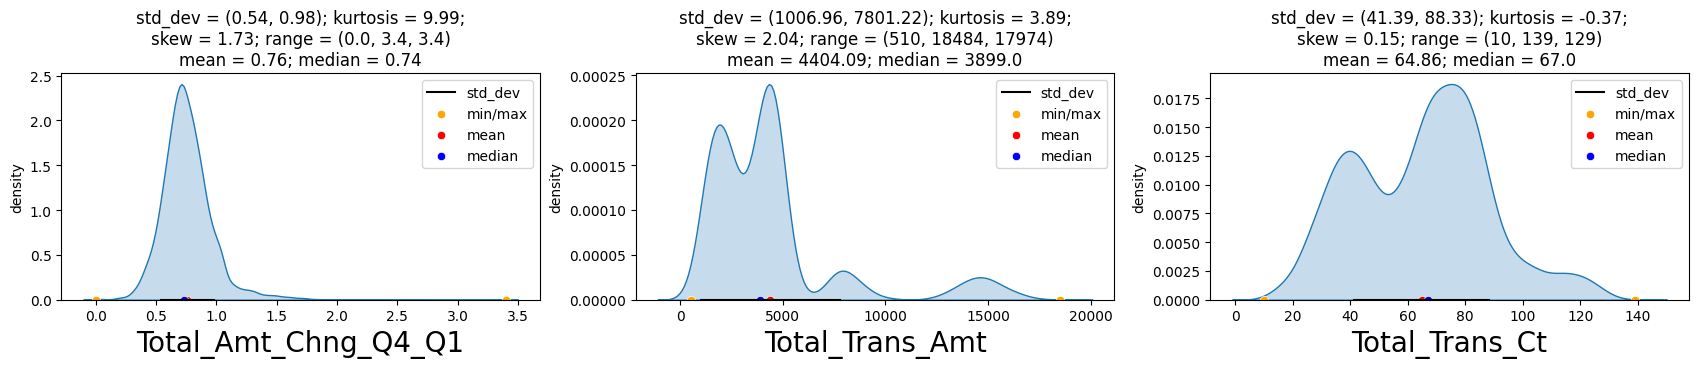

In [17]:
UVA_numeric(df,['Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct'])

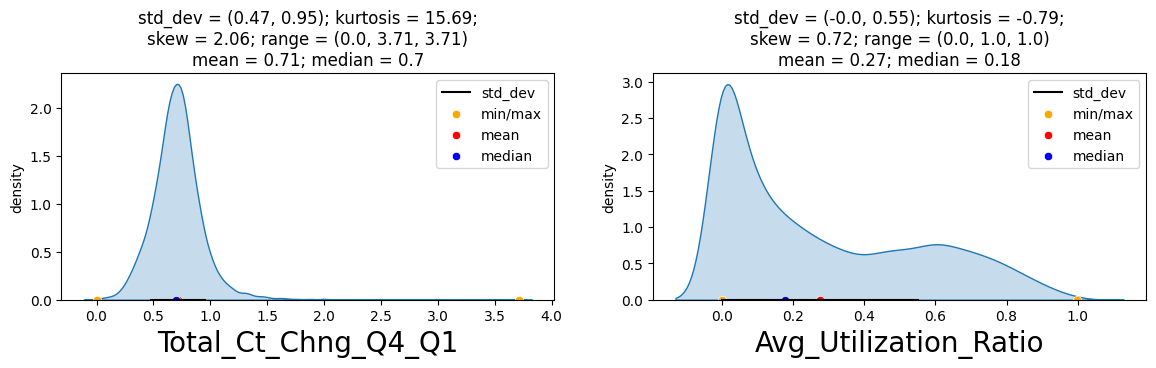

In [18]:
UVA_numeric(df,['Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio'])

- None normal distribution 

## Univarate Categorical Analysis

In [19]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,5), dpi = 100)

    # for every variable
    for j,i in enumerate(var_group):
        norm_count = data[i].value_counts(normalize = True)
        n_uni = data[i].nunique()

        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        sns.barplot(norm_count, norm_count.index , order = norm_count.index)
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel('{}'.format(i), fontsize = 20)
        plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))
        


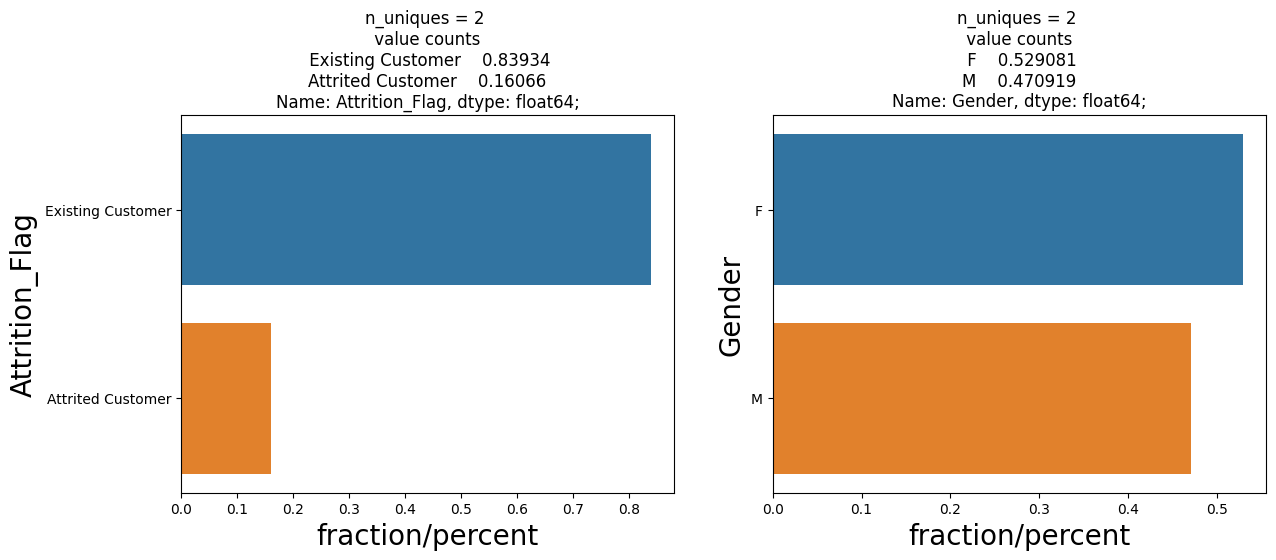

In [20]:

UVA_category(df,['Attrition_Flag',
 'Gender'])

- Fairly even balance of gender with slightly more females (OHE)
- Target variable is imbalanced 

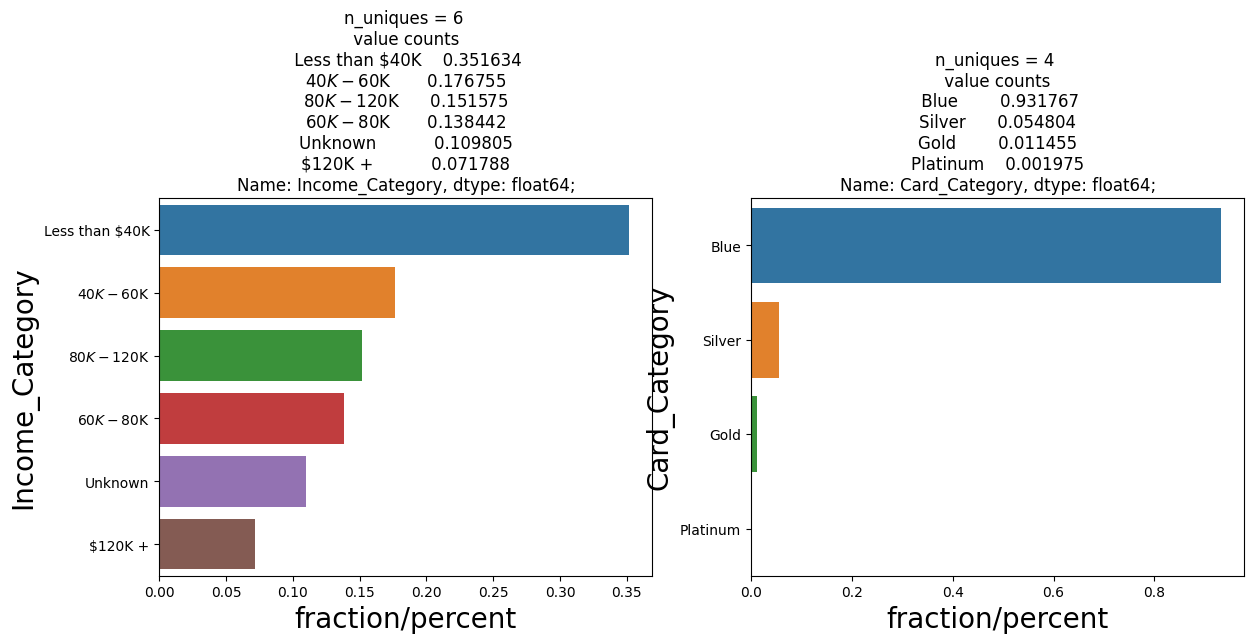

In [21]:
UVA_category(df,[
 'Income_Category',
 'Card_Category'])

- Majority of customers have the lowest card level, this feature might not provide much insight as Blue has 93% of the count 

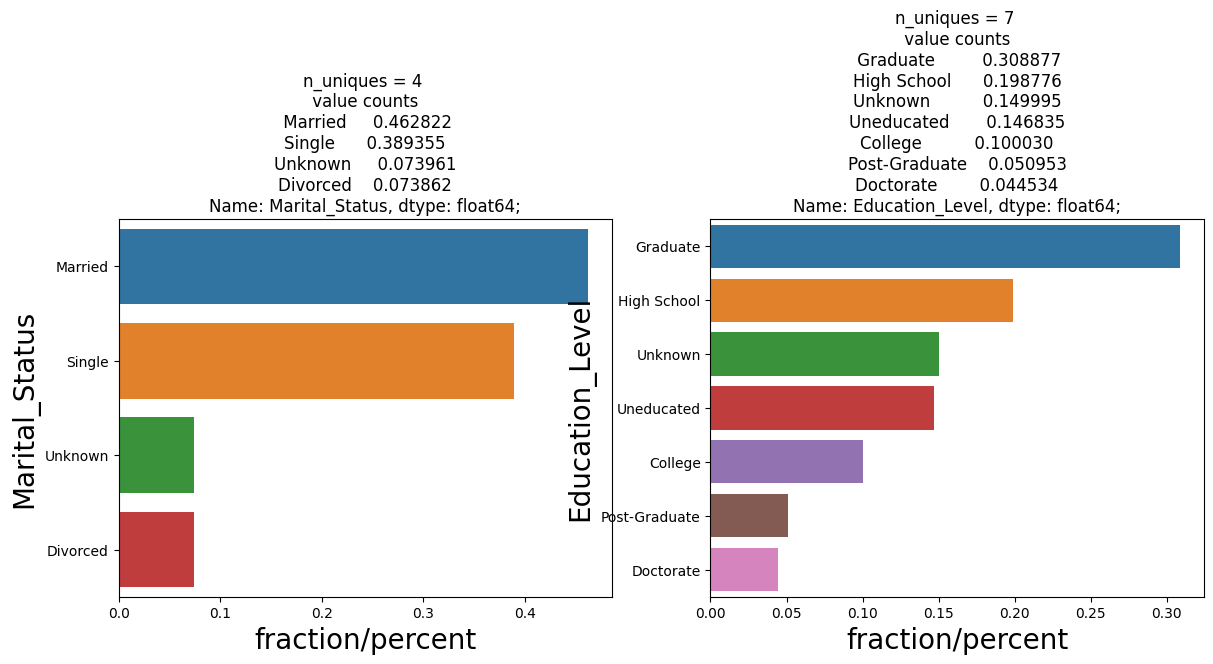

In [22]:
UVA_category(df,['Marital_Status','Education_Level'])

- Both have a sizeable amount of unknown values, we might impute for these values

## Bivariate Analysis

<Figure size 840x560 with 0 Axes>

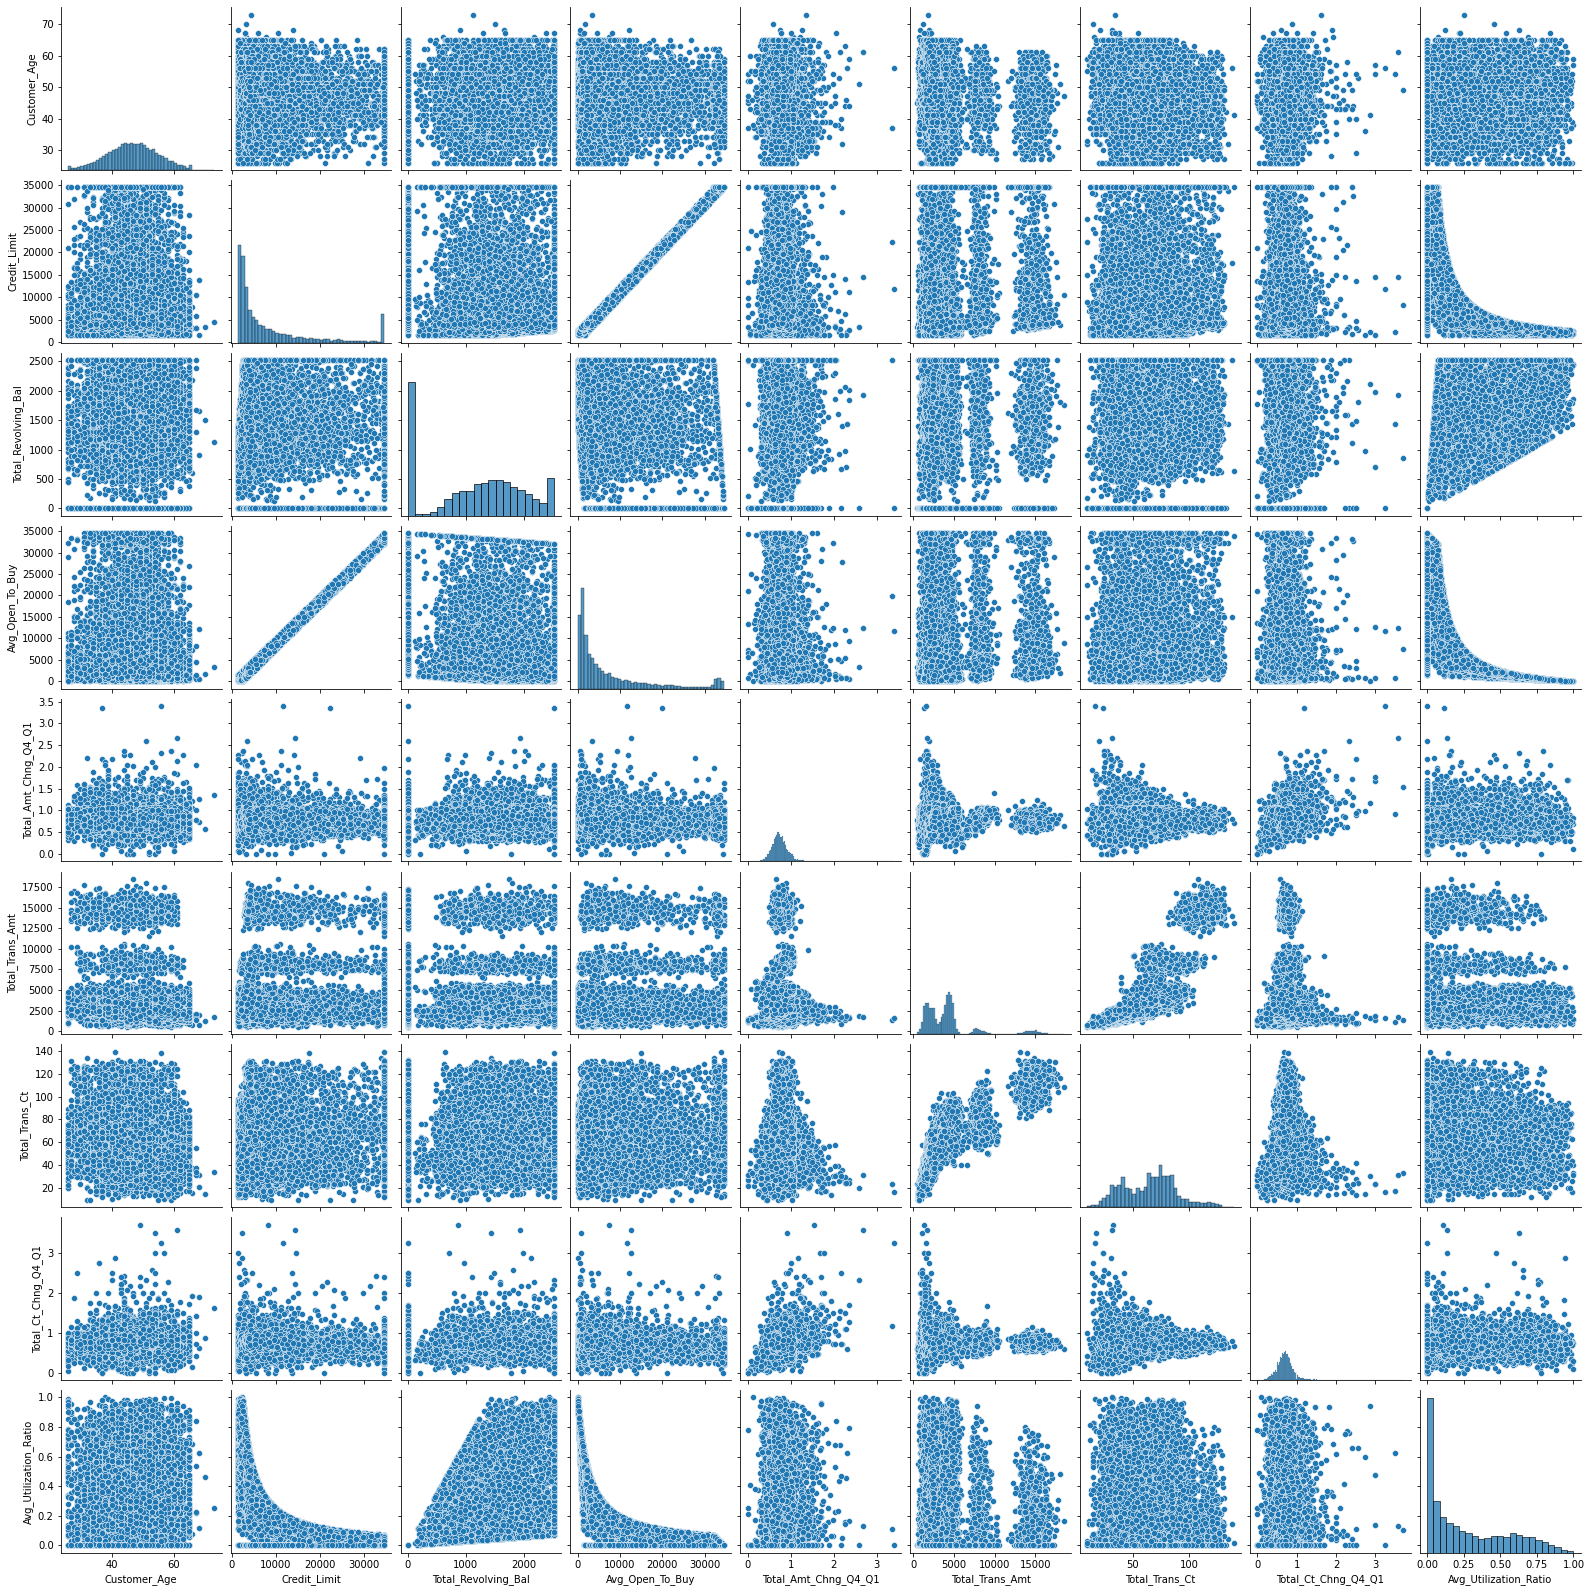

In [23]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(df[['Customer_Age',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']])
plt.show()

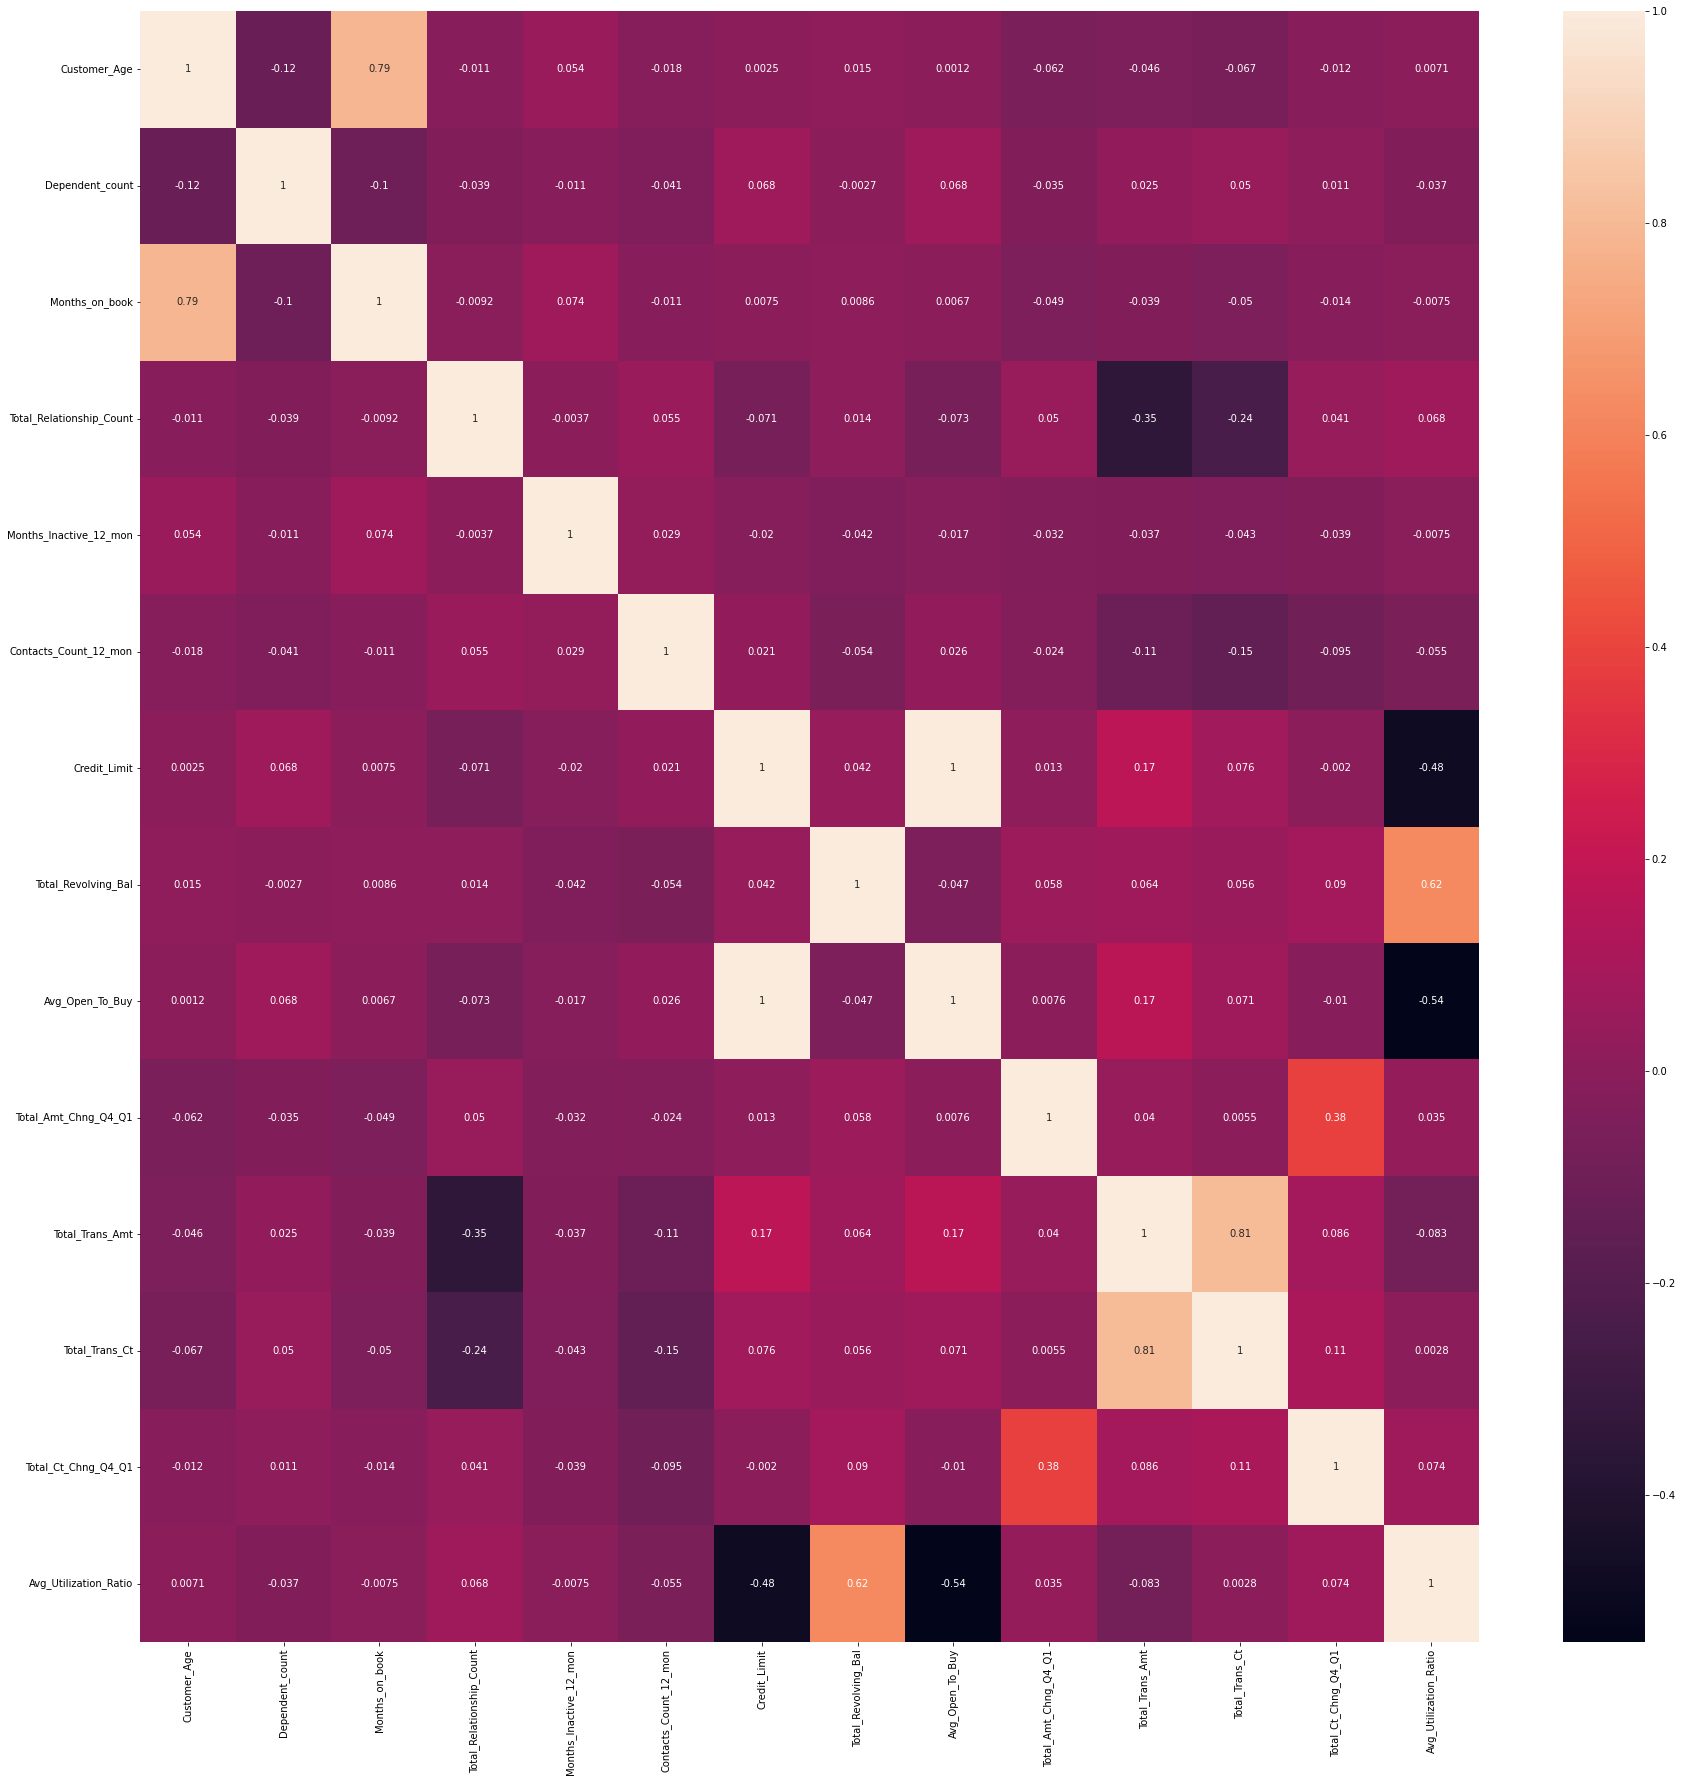

In [24]:
def correlation_matrix(data,width,height):
    '''
    :param data: dataframe
    :return: correlation matrix with heatmap
    '''
    plt.figure(figsize=(width, height))
    sns.heatmap(data.corr(), annot=True)

correlation_matrix(df,30,30)

- Months on the books is highly correlated with age , which makes sense. The older you are the longer you probably have had a credit card. 
- Total Trans Amt and Count are highly correlated, we would assume they are related features. We could potentially perform perform dimension reduction techniques if this is seen throughout - however this would effect interpretability of our model (and remember we want insights for the team)
- Credit Limit is negatively correlated with Utilisation Ratio

## Data Preprocessing

### Split the data

In [53]:
codes = {'Existing Customer':0, 'Attrited Customer':1}
df['Attrition_Flag'] = df['Attrition_Flag'].map(codes)

y = df['Attrition_Flag']
X = df.drop('Attrition_Flag',errors='ignore',axis=1)
df.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, shuffle= True,stratify = y)
# By using a stratified split, the raito of 1 and 0s are consistent btwn the two splits 
print(y_train.value_counts())
print(y_test.value_counts())

0    6799
1    1302
Name: Attrition_Flag, dtype: int64
0    1701
1     325
Name: Attrition_Flag, dtype: int64


We are using 20% of our data for our testing, an important thing to note here is that we stratify the target variable. This is extremely important as we have an imbalanced class, thus by stratifying the target we ensure we get an even ratio in both the training and test data. This will help prevent us from over/underfitting the data due to our training having a large/small portion of churn customers

###  Label Encoding
Machine learning algorithms are very picky and dont like string inputs, therefore in order to use string values in our model we encode them as numeric. There are several methods for this 
- Label Encoding for ordinal variables (ex: rankings, scales, etc)
- One Hot Encoding for nominal variables (ex: color, gender, etc.)



In [27]:
encoded = ['Gender', 'Education_Level', 'Marital_Status','Income_Category','Card_Category']

In [28]:

def encode_pipeline(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(feature_to_encode, axis=1)
    return(res) 
X_train = encode_pipeline(X_train,encoded)




In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [30]:
req_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
            'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
            'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
            'Avg_Utilization_Ratio']

In [33]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train[req_cols])

X_test = scaler.transform(X_test[req_cols])

# Model Building

## Classification Report 
A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report<br>
TN / True Negative: when a case was negative and predicted negative<br>
TP / True Positive: when a case was positive and predicted positive<br>
FN / False Negative: when a case was positive but predicted negative<br>
FP / False Positive: when a case was negative but predicted positive

### **Precision** – What percent of your predictions were correct?

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

TP – True Positives
FP – False Positives

Precision – Accuracy of positive predictions.
Precision = TP/(TP + FP)

### Recall – What percent of the positive cases did you catch? 


Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
<br>FN – False Negatives


Recall: Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)


### F1 score – What percent of positive predictions were correct? 


The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.


F1 Score = 2*(Recall * Precision) / (Recall + Precision)



## Confusion Matrix
**Confusion Matrix** is a tool to determine the performance of classifier. It contains information about actual and predicted classifications. The below table shows confusion matrix of two-class, churned customers and non-churned customers classifier. 

**True Positive (TP)** is the number of correct predictions that an example is positive which means positive class correctly identified as positive. Example: Given class is churned and the classifier has been correctly predicted it as churned. 

**False Negative (FN)** is the number of incorrect predictions that an example is negative which means positive class incorrectly identified as negative. Example: Given class is churned however, the classifier has been incorrectly predicted it as non-churned. 

**False positive (FP)** is the number of incorrect predictions that an example is positive which means negative class incorrectly identified as positive. Example: Given class is non-churned however, the classifier has been incorrectly predicted it as churned. 

**True Negative (TN)** is the number of correct predictions that an example is negative which means negative class correctly identified as negative. Example: Given class is not churned and the classifier has been correctly predicted it as not negative.

## Cross Validation
### What is Overfitting?
Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model

### What is Cross Validation? 
Cross-Validation is a resampling technique with the fundamental idea of splitting the dataset into 2 parts- training data and test data. Train data is used to train the model and the unseen test data is used for prediction. If the model performs well over the test data and gives good accuracy, it means the model hasn’t overfitted the training data and can be used for prediction.

### Why I chose K-fold?
The best part about this method is each data point gets to be in the test set exactly once and gets to be part of the training set k-1 times. As the number of folds k increases, the variance also decreases (low variance). This method leads to intermediate bias because each training set contains fewer observations (k-1)n/k than the Leave One Out method but more than the Hold Out method.

Typically, K-fold Cross Validation is performed using k=5 or k=10 as these values have been empirically shown to yield test error estimates that neither have high bias nor high variance.

The major disadvantage of this method is that the model has to be run from scratch k-times and is computationally expensive than the Hold Out method but better than the Leave One Out method. However since the dataset is small this doesnt become a problem and thus this is by far the best choice 

# AUC 
When we need to check or visualize the performance of the multi-class classification problem, we use the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

## What is the AUC - ROC Curve? <br> 
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

## How to interpret the performance of the model?
An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

In [77]:

models = [AdaBoostClassifier(random_state=0),
          GradientBoostingClassifier(random_state=0),
          RandomForestClassifier(random_state=0),
          ExtraTreesClassifier(random_state = 0),
          DecisionTreeClassifier(random_state = 0),
          lgbm.LGBMClassifier(random_state = 0),
          XGBClassifier(random_state = 0)]
model_names =[ "RandomForestClassifier","AdaBoostClassifier","Gradient Boosting",
'ExtraTreesClassifier','DecisionTreeClassifier','LightGBMClassifier', 'XGBoostClassifer']

   CrossVal_Score_Means  CrossValerrors                    Algo
0              0.954204        0.007791  RandomForestClassifier
1              0.965931        0.008319      AdaBoostClassifier
2              0.962844        0.006307       Gradient Boosting
3              0.947168        0.005137    ExtraTreesClassifier
4              0.936306        0.008791  DecisionTreeClassifier
5              0.971610        0.007525      LightGBMClassifier
6              0.970375        0.008745        XGBoostClassifer


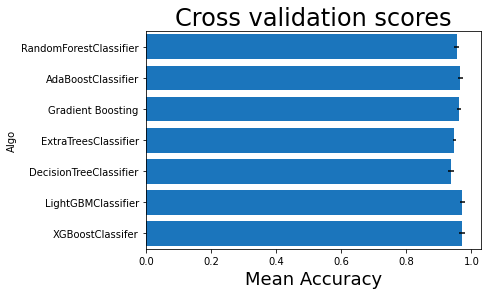

<Figure size 864x576 with 0 Axes>

In [78]:
def cross_validation_classifiers(models,model_names):
    kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)

    clrs = []
    for model in models:
        clrs.append(model)
    cv_results = []
    for clr in clrs :
        cv_results.append(cross_val_score(clr, X_train, y_train , scoring = 'accuracy', cv = kfold, n_jobs=-1))

    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    cv_df = pd.DataFrame({"CrossVal_Score_Means":cv_means,"CrossValerrors": cv_std,"Algo":model_names})
    g = sns.barplot("CrossVal_Score_Means","Algo",data = cv_df,orient = "h",**{'xerr':cv_std},color = '#0078d7')
    g.set_xlabel("Mean Accuracy",fontsize = 18)
    g = g.set_title("Cross validation scores",fontsize = 24)
    plt.figure(figsize = (12,8))
    print(cv_df)
cross_validation_classifiers(models,model_names)

## LightBGM 

In [81]:
#%% Initial fit using RandomForestClassifier
lgbm_cl = lgbm.LGBMClassifier(random_state = 0)
lgbm_cl.fit(X_train,y_train)

print(lgbm_cl.score(X_test, y_test)*100)

# Checking the Classification Report (Hidden Input)

print(classification_report(y_test, lgbm_cl.predict(X_test)))

97.03849950641658
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.93      0.88      0.90       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



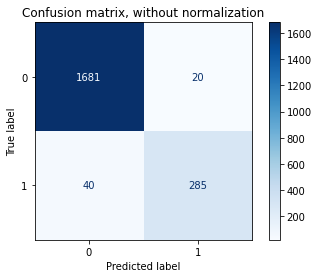

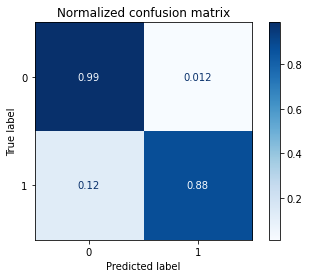

In [85]:
confusion_matrix(lgbm_cl)

In [88]:
score = roc_auc_score(y_test,lgbm_cl.predict(X_test))
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.933


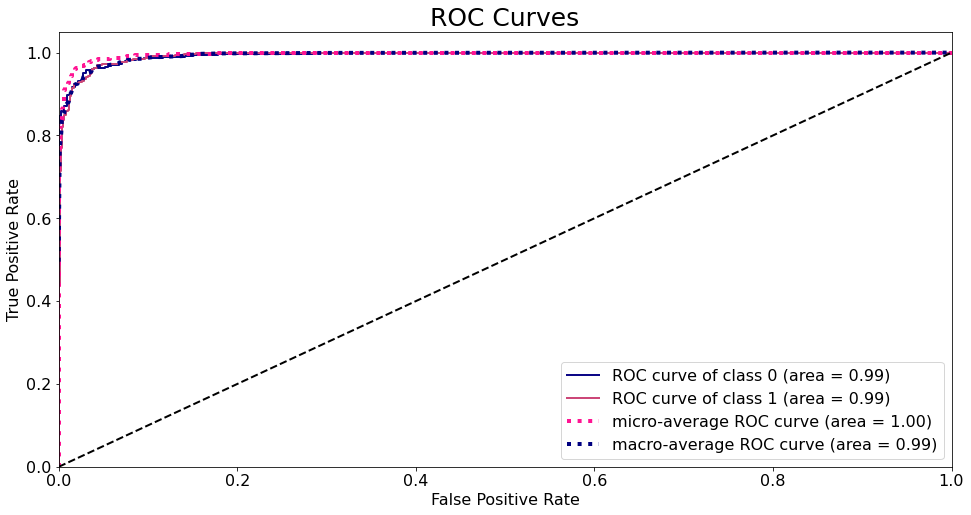

Overall AUC: 0.933


In [119]:
def ROC_curve(model,X_test, y_test):
    y_true = y_test # ground truth label
    y_probas = model.predict_proba(X_test) # predicted probabilities generated by sklearn classifier

    skplt.metrics.plot_roc(y_true, y_probas, figsize=(16,8), title_fontsize=25, text_fontsize=16, cmap='plasma')
    plt.grid(False)
    plt.show()
    score = roc_auc_score(y_test,model.predict(X_test))
    print("Overall AUC: {:.3f}" .format(score))
ROC_curve(lgbm_cl,X_test,y_test)

/var/folders/yt/tb5v0shj3l17fyn2bw5qqw3h0000gn/T/ipykernel_12869/2115496597.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(best_vars, size=12)


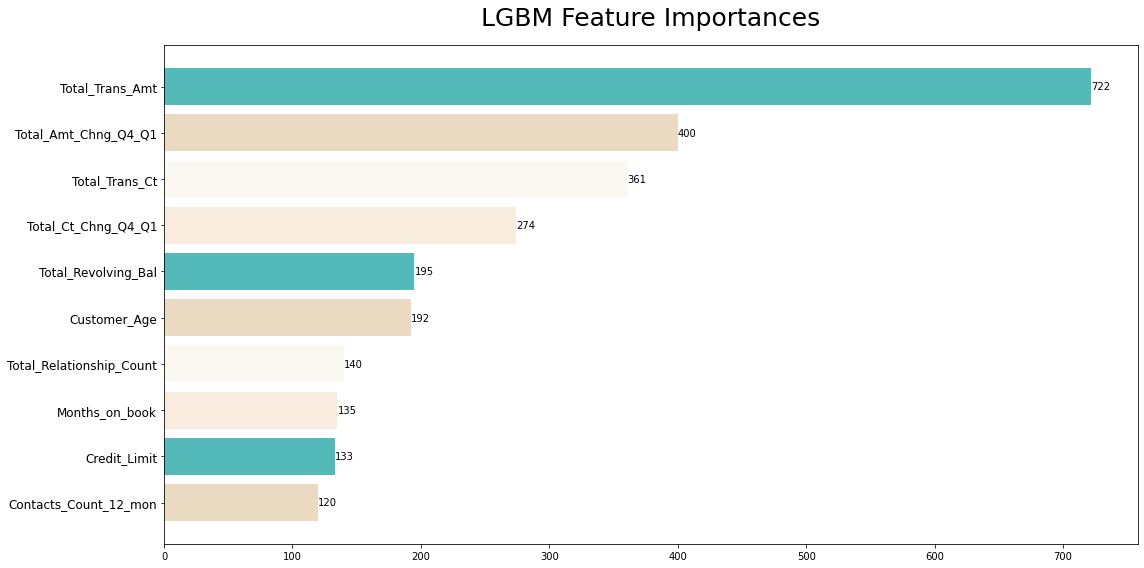

In [120]:
# Plotting the important features (Hidden Input)
def feature_importance_plot(fitted_model,model_name,req_cols,num_features_plot):
    model = fitted_model
    features_to_plot = num_features_plot

    importances = model.feature_importances_
    indices = np.argsort(importances)

    best_vars = np.array(req_cols)[indices][-features_to_plot:]
    values = importances[indices][-features_to_plot:]
    best_vars

    y_ticks = np.arange(0, features_to_plot)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.barh(y_ticks, values, color=['#E9DAC1','#54BAB9','#F7ECDE','#FBF8F1'])
    ax.set_yticklabels(best_vars, size=12)
    ax.set_yticks(y_ticks)
    ax.set_title("{} Feature Importances".format(str(model_name)), size=25, pad=20, color='black')
    ax.bar_label(ax.containers[0], size="10")
    fig.tight_layout()
    plt.grid(False)
    plt.show()
    
feature_importance_plot(lgbm_cl,"LGBM",req_cols,10)

## XGBoost

In [86]:
#%% Initial fit using RandomForestClassifier
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train,y_train)

print(xgb.score(X_test, y_test)*100)

# Checking the Classification Report (Hidden Input)

print(classification_report(y_test, xgb.predict(X_test)))

97.18657453109576
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



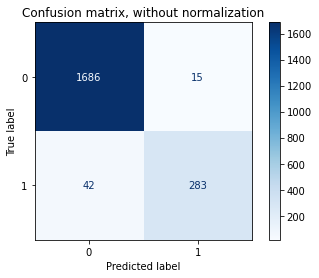

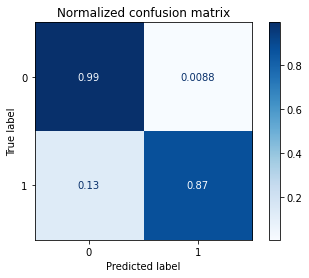

In [90]:
confusion_matrix(xgb)

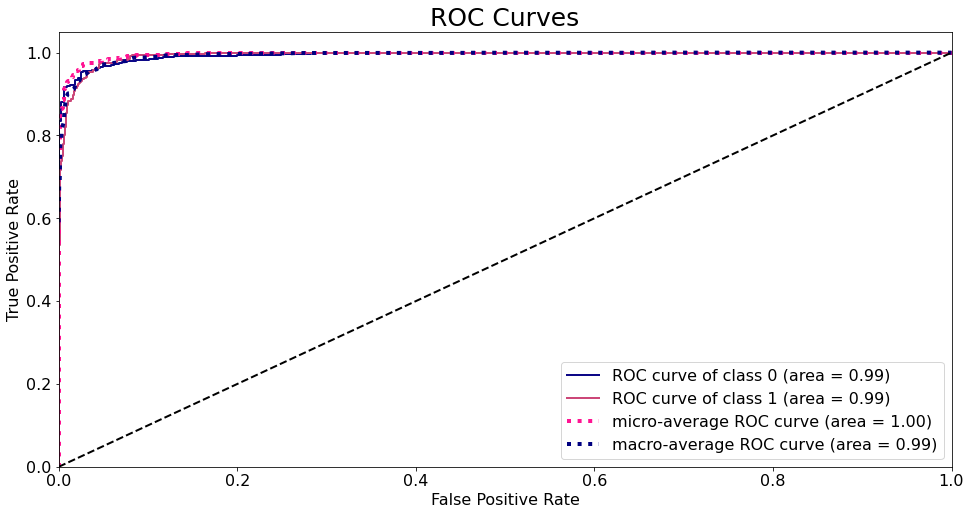

Overall AUC: 0.931


In [121]:
ROC_curve(xgb,X_test,y_test)

/var/folders/yt/tb5v0shj3l17fyn2bw5qqw3h0000gn/T/ipykernel_12869/2115496597.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(best_vars, size=12)


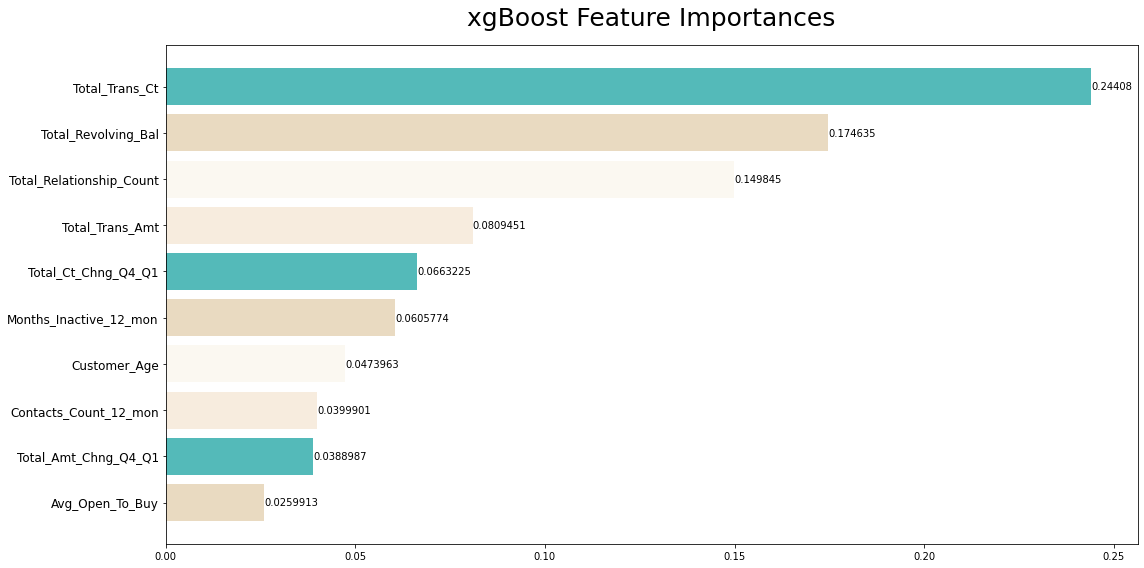

In [122]:
feature_importance_plot(xgb,"xgBoost",req_cols,10)

## GradientBoost

In [92]:

#%% Initial fit using RandomForestClassifier
gb =GradientBoostingClassifier(random_state=0)
gb.fit(X_train,y_train)

print(gb.score(X_test, y_test)*100)

# Checking the Classification Report (Hidden Input)

print(classification_report(y_test, gb.predict(X_test)))

96.44619940769991
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1701
           1       0.94      0.83      0.88       325

    accuracy                           0.96      2026
   macro avg       0.96      0.91      0.93      2026
weighted avg       0.96      0.96      0.96      2026



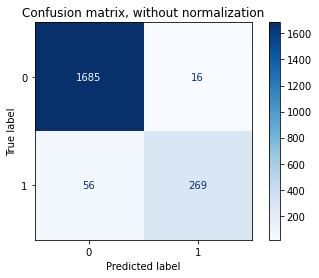

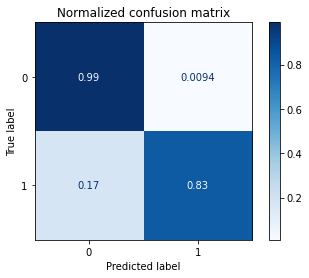

In [96]:
confusion_matrix(gb)

In [93]:
score = roc_auc_score(y_test,gb.predict(X_test))
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.909


## AdaBoost

In [94]:

#%% Initial fit using RandomForestClassifier
ada =AdaBoostClassifier(random_state=0)
ada.fit(X_train,y_train)

print(ada.score(X_test, y_test)*100)

# Checking the Classification Report (Hidden Input)

print(classification_report(y_test, ada.predict(X_test)))

95.55774925962488
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1701
           1       0.90      0.82      0.85       325

    accuracy                           0.96      2026
   macro avg       0.93      0.90      0.91      2026
weighted avg       0.95      0.96      0.95      2026



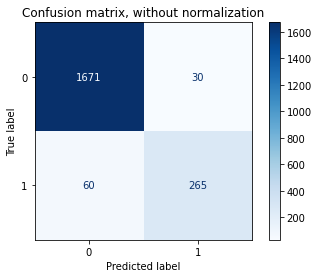

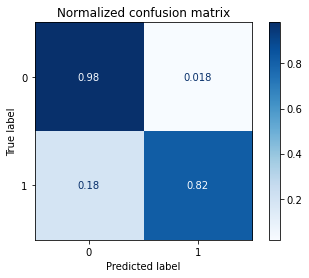

In [97]:
confusion_matrix(ada)

In [98]:
score = roc_auc_score(y_test,ada.predict(X_test))
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.899


Our best model is LightGBM with an AUC Score of .933

In [123]:
from sklearn.ensemble import VotingClassifier
clf1 = lgbm_cl
clf2 = xgb
clf3 = AdaBoostClassifier()
eclf1 = VotingClassifier(estimators=[('lgbm', clf1), ('xgb', clf2)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Final Accuracy Score ")
print(accuracy_score(y_test, predictions))

Final Accuracy Score 
0.9733464955577492


# Conclusion 
We can now provide the bank with actionable insights, they can insert new data into our trained model and with a high degree of confidence they will know which customers to focus on in order to reduce churn and increase the retention rate

# Whats next? 
- I will hopefully develop a web application that the bank can you to input data about customers and we get a probability on if they will churn or not. 
- Further data exploration in SQL with a connected Dashboard in Tableau for quick insights